In [2]:
import random
import numpy as np
import json
from PIL import Image, ImageFilter
import glob
import math

import chainer
from chainer import datasets
import chainer.functions as F
import chainer.links as L

import pylab as plt
import matplotlib.pyplot as plt


/miniconda3/lib/python3.7/site-packages/chainer/_environment_check.py:37: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


7390


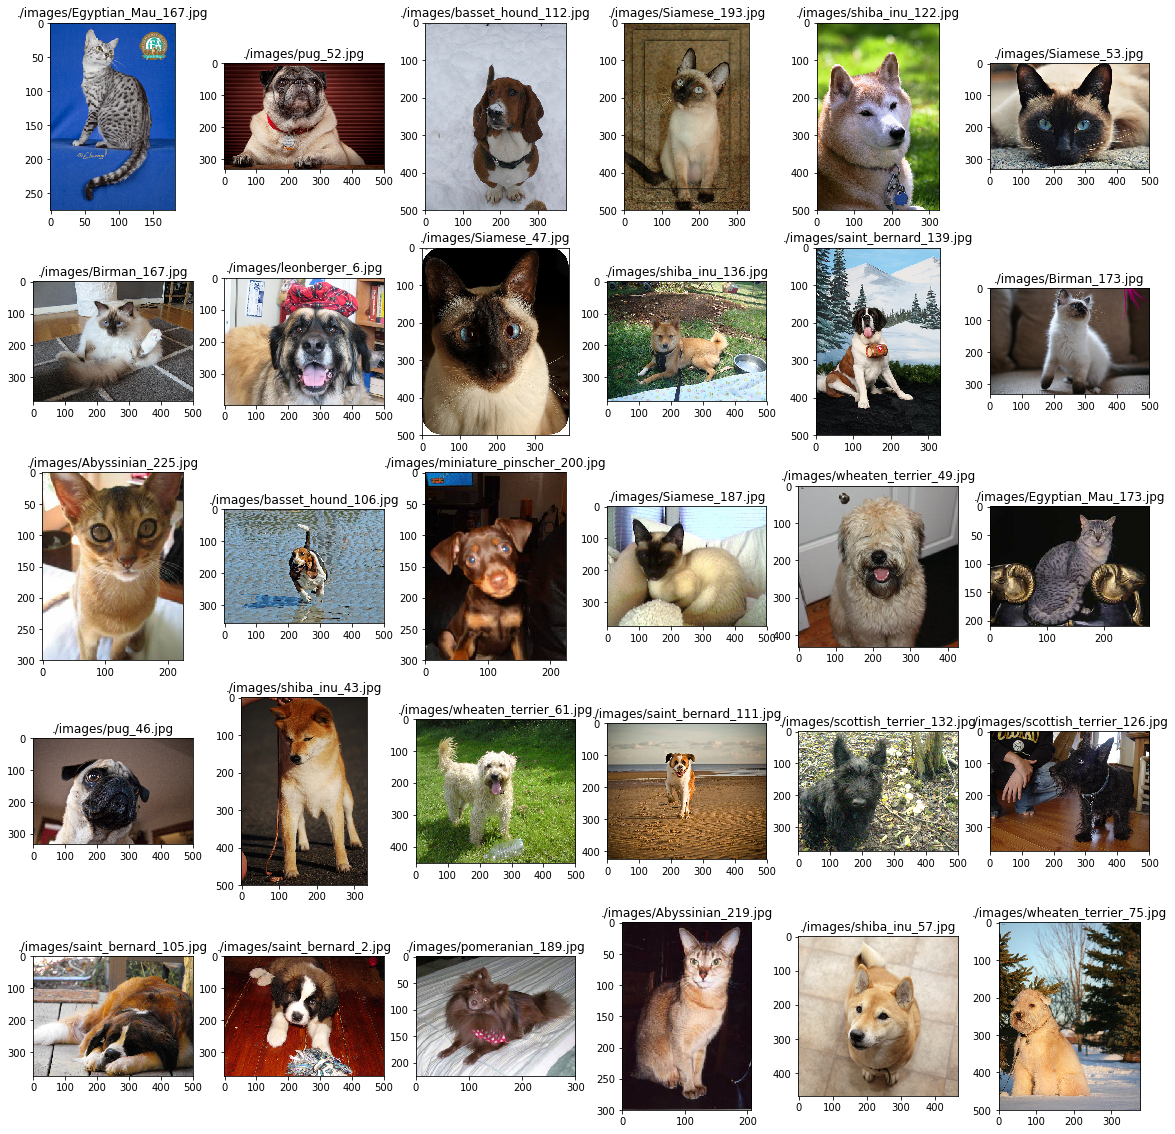

In [4]:
#Get list of image
image_file = glob.glob('./images/*.jpg')
print(len(image_file))
plt.figure(figsize = (20, 20))
for k in range(30):
    img = Image.open(image_file[k])
    plt.subplot(5, 6, k+1)
    plt.title(image_file[k])
    plt.imshow(img)

In [14]:
#split dataset
#train data
f = open('./train.json', 'r')
train_json = json.load(f)
train_index = []
train_class = []
train_label = []
train_count = 0
for i in train_json.keys():
    for j in train_json[i].keys():
        train_count += train_json[i][j]['n_images']
        for k in train_json[i][j]['images']:
            train_index.append(k)
            train_class.append(int(train_json[i][j]['class_id']))
        if i  == 'dog':
            trian_label.append(1)
        elif i == 'cat':
            trian_label.append(0)
        else:
            print('not found class')
f.close()

#test data
f = open('./test.json', 'r')
test_json = json.load(f)
test_index = []
test_class = []
test_label = []
test_count = 0
for i in test_json.keys():
    for j in test_json[i].keys():
        test_count += train_json[i][j]['n_images']
        for k in test_json[i][j]['images']:
            test_index.append(k)
            test_class.append(int(train_json[i][j]['class_id']))
        if i  == 'dog':
            test_label.append(1)
        elif i == 'cat':
            test_label.append(0)
        else:
            print('not found class')
f.close()

/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


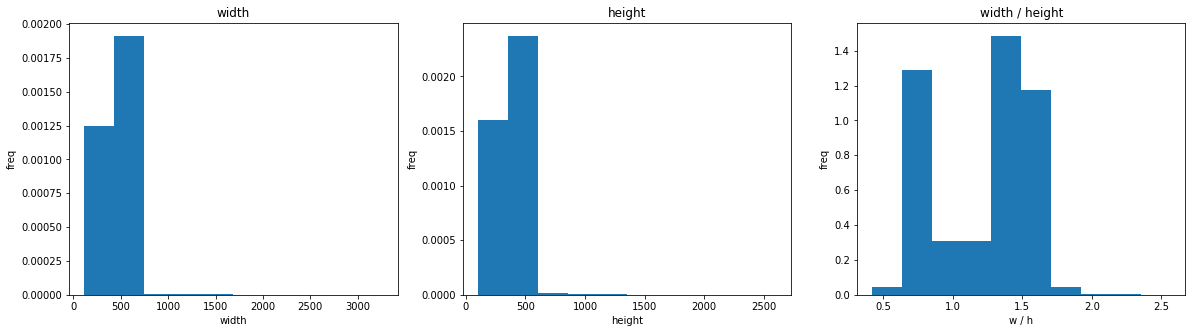

In [14]:
#statistics of image size
w_list, h_list, rate_list = [], [], []
for i in range(len(image_file)):
    img = Image.open(image_file[i])
    w, h = img.size
    w_list.append(w)
    h_list.append(h)
    rate_list.append(w/h)
    
#plot histogram
plt.figure(figsize=(20, 5))
# width
plt.subplot(1, 3, 1)
plt.hist(w_list, bins=10, normed=True)
plt.title('width')
plt.xlabel('width')
plt.ylabel('freq')

# height
plt.subplot(1, 3, 2)
plt.hist(h_list, bins=10, normed=True)
plt.title('height')
plt.xlabel('height')
plt.ylabel('freq')

# rate
plt.subplot(1, 3, 3)
plt.hist(rate_list, bins=10, normed=True)
plt.title('width / height')
plt.xlabel('w / h')
plt.ylabel('freq')
plt.show()

The range of image size is from 200px to 1800px, maximum of width/hight is about 2.3.
The features of image data are:
1. Images are centrosymmetic
2. Images appear to reverse left and right, up and down.

In [16]:
#prepocessing
def load_image(image_path, augmentation = False, size = (224, 224)):
    img = Image.open(image_path)
    
    #make a square from the shorter side
    x_center = img.size[0] // 2
    y_center = img.size[1] // 2
    half_short_side = min(x_center, y_center)
    x0 = x_center - half_short_side
    y0 = y_center - half_short_side
    x1 = x_center + half_short_side
    y1 = y_center + half_short_side
    
    # Augmentation
    if augmentation:
        # rotation
        if np.random.random() > 0.6:
            angle = np.random.randint(-10, 10)
            img = img.rotate(angle, resample=Image.BILINEAR)
        # flip
        if np.random.random() > 0.6:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        # shift and scaling
        if np.random.random() > 0.5:
            range_x = img.size[0] // 60
            range_y = img.size[1] // 60
            x0 = max(0, np.random.randint(x0 - range_x, x0 + range_x))
            y0 = max(0, np.random.randint(y0 - range_y, y0 + range_y))
            x1 = min(img.size[0], np.random.randint(x1 - range_x, x1 + range_x))
            y1 = min(img.size[1], np.random.randint(y1 - range_y, y1 + range_y))

    img = img.crop((x0, y0, x1, y1))
    img = img.resize(size)
    img = np.array(img, dtype=np.uint8)
    return img

In [17]:
#load train image
train_img = []
for name in train_index:
    img_file = './images/{}.jpg'.format(name)
    img = load_image(img_file, augmentation = True)
    train_img.append(img)

In [139]:
# train
train_dict = {}
print(len(train_img))
print(train_img[0].shape)

1967
(224, 224, 3)


In [20]:
#load test image
test_img = []
for name in test_index:
    img_file = './images/{}.jpg'.format(name)
    img = load_image(img_file, augmentation=True)
    test_img.append(img)

In [125]:
# test
print(len(test_img))
print(type(test_img))

5382
<class 'list'>


In [144]:
#Triplet dataset
class PetsTripletDataset(chainer.dataset.DatasetMixin):
    def __init__(self, train, class_id):
        
        train = chainer.datasets.LabeledImageDataset(train_img, train_label)
        test = chainer.datasets.LabeledImageDataset(test_img, test_label)
        
        self.X = train
        self.T = class_id
        self.t2inds = {} #label to index
        self.labels = np.arange(7, dtype=np.int32)
        self.tlabels = np.array(list(set(class_id)))

        
        ind = 0
        for x, t in zip(train, class_id):
            if t not in self.t2inds:
                self.t2inds[t] = []
            self.t2inds[t].append(ind)
            ind += 1
        self.T = np.array(self.T, dtype=np.int32)

    def __len__(self):
        return len(self.T)

    def get_example(self, i):
#         x = self.X[i]
#         t = self.T[i]
        x = self.make_batch(self.X[i], dataFrag=True)#.reshape(3, 224, 224)
        t = self.make_batch(self.T[i], dataFrag=False)

        # positive sample
#         ind_p = np.random.choice(self.t2inds[t])
#         x_p = self.X[ind_p]
        ind_p = np.random.choice(self.t2inds[self.T[i]])
        x_p = self.make_batch(self.X[ind_p], dataFrag=True)#.reshape(3, 224, 224)

        # negative sample
#         label = np.random.choice(self.tlabels[self.tlabels!=t])
#         ind_n = np.random.choice(self.t2inds[label])
#         x_n = self.X[ind_n]
        label = np.random.choice(self.tlabels[self.tlabels!=self.T[i]])
        ind_n = np.random.choice(self.t2inds[label])
        x_n = self.make_batch(self.X[ind_n], dataFrag=True)#.reshape(3, 224, 224)
        return x, t, x_p, x_n

        
        ''''ind = 0
        for x, t in zip(train, tag_id):
            if t not in self.t2inds:
                self.t2inds[t] = []
            self.X.append(x)
            self.T.append(t)
            self.t2inds[t].append(ind)
            ind += 1

        #self.X = np.array(self.X, dtype=np.float32)
        self.T = np.array(self.T, dtype=np.int32)
    
    def __len__(self):
        return len(self.T)

    def get_example(self, i):
        x = self.make_batch(self.X[i])
        t = self.make_batch(self.T[i])
        
        # positive sample
        ind_p = np.random.choice(self.t2inds[self.T[i]])
        x_p = self.make_batch(self.X[ind_p])

        # negative sample
        label = np.random.choice(self.tlabels[self.labels!=t])
        ind_n = np.random.choice(self.t2inds[label])
        x_n = self.make_batch(self.X[ind_n])

        return x, t, x_p, x_n'''
    
    def make_batch(self, img, dataFrag=True):
        batch_list = []
        if dataFrag:
            img = img.transpose(2, 0, 1)
            img = img[::-1]
            img -= np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(3, 1, 1)
            return np.array(img, dtype=np.float32)
        else:
            return np.array(img, dtype=np.int32)

In [146]:
dataset  = PetsTripletDataset(train_img, train_label)
#dataset= chainer.datasets.LabeledImageDataset(train_img, train_label)
#print(type(dataset))

ValueError: too many values to unpack (expected 2)

In [147]:
print(len(dataset))

1967


In [148]:
#test positive&negative
x, t, x_p, x_n = dataset[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('label:{}'.format(t))
plt.imshow(x.reshape(28, 28))

plt.subplot(1, 3, 2)
plt.title('positive')
plt.imshow(x_p.reshape(28, 28))

plt.subplot(1, 3, 3)
plt.title('negative')
plt.imshow(x_n.reshape(28, 28))

ValueError: too many values to unpack (expected 2)

In [75]:
#ResNet model
class ResNet152(chainer.Chain):
    def __init__(self, n_blocks=[3, 8, 36, 3]):
        w = chainer.initializers.HeNormal()
        super(ResNet152, self).__init__(
            conv1=L.Convolution2D(
                None, 64, 7, 2, 3, initialW=w, nobias=True),
            bn1=L.BatchNormalization(64),
            res2=ResBlock(n_blocks[0], 64, 64, 256, 1),
            res3=ResBlock(n_blocks[1], 256, 128, 512),
            res4=ResBlock(n_blocks[2], 512, 256, 1024),
            res5=ResBlock(n_blocks[3], 1024, 512, 2048),
            fc6=L.Linear(2048, 1000))

    def __call__(self, x):
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), 2, 2)
        h = self.res2(h)
        h = self.res3(h)
        h = self.res4(h)
        h = self.res5(h)
        h = F.average_pooling_2d(h, h.shape[2:], stride=1)
        h = self.fc6(h)
        if chainer.config.train:
            return h
        return F.softmax(h)


In [76]:
class ResBlock(chainer.ChainList):
    def __init__(self, n_layers, n_in, n_mid, n_out, stride=2):
        w = chainer.initializers.HeNormal()
        super(ResBlock, self).__init__()
        self.add_link(BottleNeck(n_in, n_mid, n_out, stride, True))
        for _ in range(n_layers - 1):
            self.add_link(BottleNeck(n_out, n_mid, n_out))

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

In [77]:
class BottleNeck(chainer.Chain):
    def __init__(self, n_in, n_mid, n_out, stride=1, proj=False):
        w = chainer.initializers.HeNormal()
        super(BottleNeck, self).__init__()
        with self.init_scope():
            self.conv1x1a = L.Convolution2D(
                n_in, n_mid, 1, stride, 0, initialW=w, nobias=True)
            self.conv3x3b = L.Convolution2D(
                n_mid, n_mid, 3, 1, 1, initialW=w, nobias=True)
            self.conv1x1c = L.Convolution2D(
                n_mid, n_out, 1, 1, 0, initialW=w, nobias=True)
            self.bn_a = L.BatchNormalization(n_mid)
            self.bn_b = L.BatchNormalization(n_mid)
            self.bn_c = L.BatchNormalization(n_out)
            if proj:
                self.conv1x1r = L.Convolution2D(
                    n_in, n_out, 1, stride, 0, initialW=w, nobias=True)
                self.bn_r = L.BatchNormalization(n_out)
        self.proj = proj

    def __call__(self, x):
        h = F.relu(self.bn_a(self.conv1x1a(x)))
        h = F.relu(self.bn_b(self.conv3x3b(h)))
        h = self.bn_c(self.conv1x1c(h))
        if self.proj:
            x = self.bn_r(self.conv1x1r(x))
        return F.relu(h + x)


In [78]:
class TripletLoss(chainer.Chain):
    def __init__(self, model):
        super(TripletLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, t, x_p, x_n):
        y = self.model(x)
        y_p = self.model(x_p)
        y_n = self.model(x_n)
        loss = F.triplet(y, y_p, y_n)
        
        y_0 = y[t==0]
        if len(y_0) > 0:
            loss += F.mean((y_0 ** 2))

        chainer.report({'loss': loss}, self)
        return loss

In [80]:
model = ResNet152()
loss = TripletLoss(model)

In [ ]:
#train
from chainer import iterator
from chainer import training
from chainer.training extensions 